### 2\. Satellite subscenes

Redo the [satellite_subscene](http://clouds.eos.ubc.ca/~phil/courses/atsc212/html/satellite_subscene.html) notebook so that:

1\.  Cell [102] becomes a function that two vectors bot_rows and left_cols and a file_dict that contains the 2-d arrays of ch29, ch31 and phase and returns the scene_dict with the dataframes for each subscene

2\. Cell [110] becomes a function that takes this scene dict and returns dataframes for ch29 and ch31 with the mean brightness temperature for each subscene along the rows and the phase (0, 1, 2, 3, 4) along the coluumns.

Call these two functions with the satellite image divided into 16 rows and 8 columns so you have 128 subscenes and redo the plot of sell [109] with these 128 points.



In [1]:
from a212utils.download import download_file
from IPython.display import Image
import h5py
import pandas as pd
import numpy as np

download = False
if download:
    #
    #  satelite data for day 127 of 2014  Modis Aqua level 3 cloud data
    #
    url = 'http://clouds.eos.ubc.ca/~phil/Downloads/a212/fields.h5'
    local_file = download_file(url)
    print('downloaded {}'.format(local_file))
else:
    local_file='fields.h5'

In [12]:
with h5py.File(local_file,'r') as f:
    file_dict = {}
    vars = ['ch29','ch31','cloud_mask','phase']
    for name in vars:
        fullname = '/A2014127/{}'.format(name)
        file_dict[name] = f[fullname][...]
    file_dict.update(f.attrs.items())
    
print(file_dict.keys())
file_dict['phase']

dict_keys(['mask_vals', 'cloud_mask', 'phase_vals', 'ch29', 'ch31', 'phase'])


array([[2, 2, 2, ..., 0, 0, 0],
       [2, 2, 2, ..., 0, 0, 0],
       [2, 2, 2, ..., 0, 0, 0],
       ..., 
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 0, 1, 1],
       [1, 1, 1, ..., 1, 1, 1]], dtype=int32)

## 1\. split the image into 128 subscenes and make a dataframe for each subscene

Store the dataframes in the scene_dict, indexed by scene number

In [3]:
rows,cols=file_dict['ch29'].shape
#
# use the modulus function to find the even divisor
#
nrows = 16
ncols = 8
remainder = np.mod(rows,nrows)
rowsN = int((rows - remainder)/nrows)
remainder = np.mod(cols,ncols)
colsN = int((cols - remainder)/ncols)
left_cols=np.arange(0,ncols*colsN,colsN,dtype=np.int)
bot_rows = np.arange(0,nrows*rowsN,rowsN,dtype=np.int)

def subset_scene(left_cols,bot_rows,colsN,rowsN,file_dict):
    """
    take a dictionary containing brightness temperature and phase retrievals with
    keys 'ch29', 'ch31', 'phase'
    from the Modis instrument and return a dictionary containing dataframes for
    subscenes of each keyed variable subsetted into left_cols x bot_rows sections,
    where left_cols is a vector giving the left column of each subscene and bot_rows
    is a vector giving the bottom row of each subscene  i.e. 
    subscene 2 is ch29[botrows[2]]:botrows[2]+Nrows,leftcol[2]:leftcols[2] + Ncols]
    
    Parameters
    ----------
    
    left_cols: vector (int)
        left edge of each subscene
    bot_rows: vector (int)
        bottom edge of each subscene
    colsN: scalar (int)
        width of subscene in pixels
    rowsN: scalar (int)
        height of subscene in pixels
        
    Returns
    -------
    
    scene_dict: dict
        dictionary containing len(left_cols) x len(bot_rows) subscenes, 
        keyed by integer subscene number.  Each subscene is a dictionary
        with keys ['ch29','ch31','phase','df'], with each key pointing to a vector
        of the raw brightness temperatures/phases ['ch29','ch31','phase'] and a dataframe
        collecting the three variables into three columns ['df']
    """
    scene_dict={}
    vars = ['ch29','ch31','phase']
    scene=0
    #
    # go through the 16 subscenes
    #
    for botrow in bot_rows:
        for leftcol in left_cols:
            scene_dict[scene]={}
            row_slice=slice(botrow,botrow + rowsN)
            col_slice=slice(leftcol,leftcol + colsN)
            for var in vars:
                scene_dict[scene][var]=file_dict[var][row_slice,col_slice].ravel()
            df = pd.DataFrame(scene_dict[scene])
            scene_dict[scene]['df']=df
            scene+=1
    return scene_dict

scene_dict = subset_scene(left_cols,bot_rows,colsN,rowsN,file_dict)


### 2\. Create a dataframe for each of the 128 subscenes and add to scene_dict

This function finds the mean for each channel and each phase and saves
it in a dictionary keyed by phase.

In [4]:
def calc_means(subscene_df):
    """
    given a subscene dictionary, group by phase and find the
    mean for each phase and channel
    
    Parameters
    ----------
    
    subscene_df: dataframe
    
        dataframe with pixels on rows and columns ['phase','ch29','ch31']
    
    Returns
    -------
    
    phase_dict: dictionary
    
        nested dictionary with the phase as the key and the mean for
        each temperature as another dictionary
    """
    phase_dict={}
    groups=subscene_df.groupby('phase')
    for phase,group in groups:
        phase_dict[phase]={}
        for value in ['ch29','ch31']:
            phase_dict[phase][value]=group[value].mean()
    return phase_dict

Now combine all of the phases for a given channel so that we
can construct a dataframe for each channel with the phase
in the columns

In [5]:
def calc_temps(scene_dict):
    """
    Take the dictionare produced by subset_scene
    and return two dataframes df_29 and df_31, each
    having one row for each subscene, and a column for
    the mean brightness temperature of phases 0, 1, 3, and 4
    
    Parameters
    ----------
    
    scene_dict: dict
       dictionary with subscene dataframes containing the brightness temperatures
       and phases for each pixel in the subscene as columns (see subset_scene)
    
    Returns
    -------
      out: tuple
          tuple containing (df_29, df_31) which are the dataframes for mean brightness temperature
          of each subscene grouped by the retrieved phase of each pixel in the subscene     
    """
    ch31_dict = {0:[],1:[],2:[],3:[],4:[]}
    ch29_dict = {0:[],1:[],2:[],3:[],4:[]}
    for subscene,the_dict in scene_dict.items():
        #
        # find the average temperature for each phase in the subscne
        #
        phase_dict=calc_means(the_dict['df'])
        for phase in range(5):
            try:
                ch31_dict[phase].append(phase_dict[phase]['ch31'])
                ch29_dict[phase].append(phase_dict[phase]['ch29'])
            except KeyError:
                #
                # if the phase doesn't occur in the scene, need to
                # add np.nan as a placeholder
                #
                ch31_dict[phase].append(np.nan)
                ch29_dict[phase].append(np.nan)
    df_31=pd.DataFrame(ch31_dict)
    df_29 = pd.DataFrame(ch29_dict)
    out = (df_29, df_31)
    return out

df_29,df_31 = calc_temps(scene_dict)
df_diff = df_31 - df_29
            

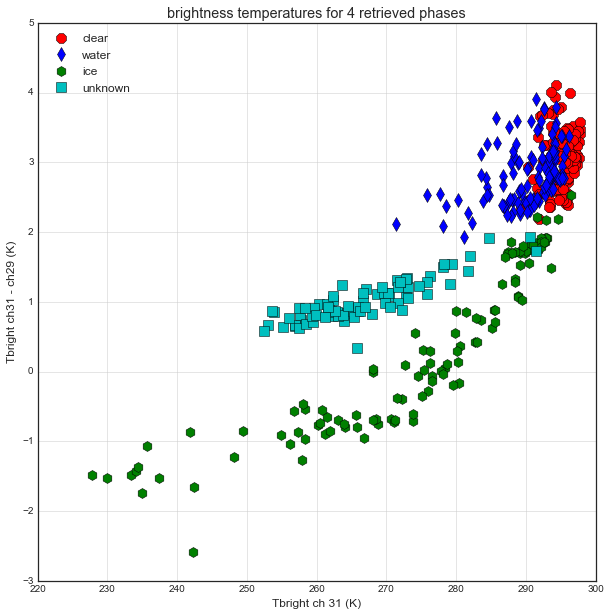

In [6]:
%matplotlib inline
plt.style.use('seaborn-white')
plt.close('all')
color_cycle =['r','b','g','c']
symbol_cycle = ['8','d','h','s']
phases = [0,1,2,4]
legend={0:'clear',1:'water',2:'ice',4:'unknown'}
fig, ax = plt.subplots(1,1,figsize=(10,10))
ax.grid()
for phase,symbol,color in zip(phases,symbol_cycle,color_cycle):
    ax.plot(df_31[phase],df_diff[phase],
                   marker=symbol,mec='k',mfc=color,ls='None',ms=10,label=legend[phase])
ax.legend(loc='best')
out=ax.set(xlabel='Tbright ch 31 (K)',ylabel='Tbright ch31 - ch29 (K)',
      title='brightness temperatures for 4 retrieved phases')